In [4]:
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as fun
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression
import os, sys

In [5]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPAK_DRIVER_PYTHON'] = sys.executable

In [6]:
spark = SparkSession.builder.master("local[2]").appName("ML_LogisticRegression").getOrCreate()

In [7]:
spark

In [12]:
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

In [13]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [14]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [15]:
df.dtypes

[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'double'),
 ('DiabetesPedigreeFunction', 'double'),
 ('Age', 'int'),
 ('Outcome', 'int')]

In [17]:
df.select("Glucose","Insulin","BMI","Age").describe().show()

+-------+-----------------+------------------+------------------+------------------+
|summary|          Glucose|           Insulin|               BMI|               Age|
+-------+-----------------+------------------+------------------+------------------+
|  count|              768|               768|               768|               768|
|   mean|     120.89453125| 79.79947916666667|31.992578124999977|33.240885416666664|
| stddev|31.97261819513622|115.24400235133803| 7.884160320375441|11.760231540678689|
|    min|                0|                 0|               0.0|                21|
|    max|              199|               846|              67.1|                81|
+-------+-----------------+------------------+------------------+------------------+



In [18]:
df.select("Glucose","Insulin","BMI","Age").describe().toPandas()

,summary,Glucose,Insulin,BMI,Age
0,count,768,768,768,768
1,mean,120.89453125,79.79947916666667,31.992578124999977,33.240885416666664
2,stddev,31.97261819513622,115.24400235133803,7.884160320375441,11.760231540678689
3,min,0,0,0.0,21
4,max,199,846,67.1,81


In [19]:
df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column) for column in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [22]:
feature_names = df.columns[:-1]

In [23]:
assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
output = assembler.transform(df).select("features","Outcome")

In [24]:
output.show(5)

+--------------------+-------+
|            features|Outcome|
+--------------------+-------+
|[6.0,148.0,72.0,3...|      1|
|[1.0,85.0,66.0,29...|      0|
|[8.0,183.0,64.0,0...|      1|
|[1.0,89.0,66.0,23...|      0|
|[0.0,137.0,40.0,3...|      1|
+--------------------+-------+
only showing top 5 rows



In [26]:
model = LogisticRegression(featuresCol='features', labelCol='Outcome')
lr = model.fit(output)

In [27]:
train_pred = lr.transform(output)

In [30]:
train_pred.show(10)

+--------------------+-------+--------------------+--------------------+----------+
|            features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[6.0,148.0,72.0,3...|      1|[-0.9530408668208...|[0.27827369047981...|       1.0|
|[1.0,85.0,66.0,29...|      0|[2.97341146352460...|[0.95135838784677...|       0.0|
|[8.0,183.0,64.0,0...|      1|[-1.3658075861049...|[0.20329803850396...|       1.0|
|[1.0,89.0,66.0,23...|      0|[3.13654116462476...|[0.95837511852188...|       0.0|
|[0.0,137.0,40.0,3...|      1|[-2.2217285429299...|[0.09781615748915...|       1.0|
|[5.0,116.0,74.0,0...|      0|[1.76126797585237...|[0.85336839410502...|       0.0|
|[3.0,78.0,50.0,32...|      1|[2.64049056654504...|[0.93342245715274...|       0.0|
|[10.0,115.0,0.0,0...|      0|[-0.5952541339566...|[0.35543022217229...|       1.0|
|[2.0,197.0,70.0,4...|      1|[-0.8922668221487...|[0.29064225652028...|    

In [31]:
y_true = train_pred.select("Outcome")
y_true = y_true.toPandas()

y_pred = train_pred.select("prediction")
y_pred = y_pred.toPandas()

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_true, y_pred)

0.7825520833333334

In [34]:
confusion_matrix(y_true, y_pred)

array([[445,  55],
       [112, 156]], dtype=int64)

In [36]:
import seaborn as sns

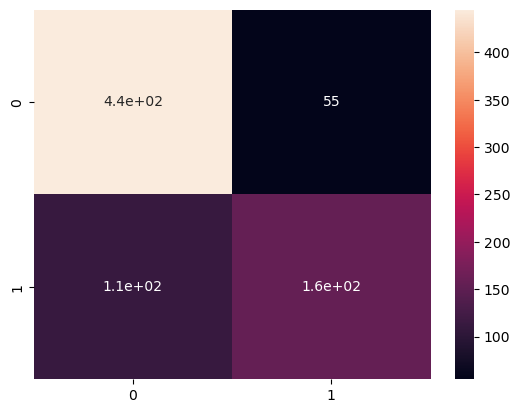

In [38]:
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
plt.show()